In [158]:
!pip install geopandas
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import pandas as pd
from geopy.distance import geodesic
import numpy as np
from shapely.geometry import Polygon

You should consider upgrading via the 'C:\FIB\DMT\Project 2\venv2\Scripts\python.exe -m pip install --upgrade pip' command.


## PROJECT ON PROCESSING AND QUERYING FOR THE FISHING COMPANY USE CASE

### 1) Data cleaning:

#### a. Calculate and report the % of missing values for temperature and chlorophyll data sets.

##### Temperature dataset

First we need to load temperature dataset and explore it for further processing.

In [159]:
temperature = pd.read_csv('data/temperature_012020-062020_res05.csv')

In [160]:
temperature

,time,latitude,longitude,temperature,partOfTheDay
0,2020-01-01,-35.25,-69.75,NaN,day
1,2020-01-01,-35.25,-69.25,NaN,day
2,2020-01-01,-35.25,-68.75,NaN,day
3,2020-01-01,-35.25,-68.25,NaN,day
4,2020-01-01,-35.25,-67.75,NaN,day
...,...,...,...,...,...
436795,2020-06-30,-49.75,-52.25,276.98440,night
436796,2020-06-30,-49.75,-51.75,275.71692,night
436797,2020-06-30,-49.75,-51.25,276.07935,night
436798,2020-06-30,-49.75,-50.75,275.07680,night


Temperature dataset has 436 800 rows of data with 5 columns.

In [161]:
temperature.shape

(436800, 5)

Columns from original dataset are stored into variable **temperature_columns**.

In [162]:
temperature_columns=temperature.columns.tolist()
temperature_columns

['time', 'latitude', 'longitude', 'temperature', 'partOfTheDay']

Function describe() gives detailed information about numerical columns. We can detect if there are outliers by looking at min or max values and comparing it with mean.

In [163]:
temperature.describe()

,latitude,longitude,temperature
count,436800.000000,436800.000000,227976.000000
mean,-42.500000,-60.000000,287.192010
std,4.327726,5.771705,4.067607
min,-49.750000,-69.750000,272.616670
25%,-46.250000,-64.875000,284.307363
50%,-42.500000,-60.000000,287.043320
75%,-38.750000,-55.125000,289.949980
max,-35.250000,-50.250000,299.702480


Dataset has 208 824 rows with NaN value and all of it is inside temperature column.

In [164]:
temperature.isna().sum()

time                 0
latitude             0
longitude            0
temperature     208824
partOfTheDay         0
dtype: int64

In [165]:
temperature.isna().sum()['temperature']

208824

% of missing values for temperature is 47.81%

In [166]:
temperature.isna().sum()['temperature']/temperature.shape[0]*100

47.80769230769231

##### Chlorophyll dataset

Loading chlorophyll dataset.

In [167]:
chlorophyll=pd.read_csv('data/chlorophylla_012020-062020_res05.csv')

In [168]:
chlorophyll

,time,latitude,longitude,chlor_a
0,2020-01-01,-35.25,-69.75,NaN
1,2020-01-01,-35.25,-69.25,NaN
2,2020-01-01,-35.25,-68.75,NaN
3,2020-01-01,-35.25,-68.25,NaN
4,2020-01-01,-35.25,-67.75,NaN
...,...,...,...,...
218395,2020-06-30,-49.75,-52.25,NaN
218396,2020-06-30,-49.75,-51.75,NaN
218397,2020-06-30,-49.75,-51.25,NaN
218398,2020-06-30,-49.75,-50.75,NaN


In [169]:
chlorophyll.shape

(218400, 4)

Name of columns are saved into variable **chlorophyll_columns**.

In [170]:
chlorophyll_columns=chlorophyll.columns.tolist()
chlorophyll_columns

['time', 'latitude', 'longitude', 'chlor_a']

Looking at detailed information about numerical columns we can assume that there is outlier of extremely large value at clor_a column which has max value of 18.489. There are no information about range chlor_a could have, so we did not deal with it.

In [171]:
chlorophyll.describe()

,latitude,longitude,chlor_a
count,218400.000000,218400.000000,100216.000000
mean,-42.500000,-60.000000,1.127495
std,4.327731,5.771711,1.232207
min,-49.750000,-69.750000,0.006210
25%,-46.250000,-64.875000,0.438345
50%,-42.500000,-60.000000,0.781977
75%,-38.750000,-55.125000,1.399674
max,-35.250000,-50.250000,18.489655


Chlorophyll dataset has 118 184 missing values inside **chlor_a** column.

In [172]:
chlorophyll.isna().sum()

time              0
latitude          0
longitude         0
chlor_a      118184
dtype: int64

% of missing values for chlorophyll is 54.11%

In [173]:
chlorophyll['chlor_a'].isna().sum()/chlorophyll.shape[0]*100

54.11355311355312

#### b. Impute missing values for the temperature and chlorophyll data sets.


##### Temperature dataset
Temperature dataset has 208 824 missing values for temperature measurements.

In [174]:
temperature.isna().sum()

time                 0
latitude             0
longitude            0
temperature     208824
partOfTheDay         0
dtype: int64

To find the optimum solution to deal with NaN values first we need to explore dataset.
There are 182 days for which are measurements taken. Data for six months is stored in dataset starting with first day on **2020-01-01** and the last one on **2020-06-30**.

In [175]:
temperature.time.unique()

array(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04',
       '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08',
       '2020-01-09', '2020-01-10', '2020-01-11', '2020-01-12',
       '2020-01-13', '2020-01-14', '2020-01-15', '2020-01-16',
       '2020-01-17', '2020-01-18', '2020-01-19', '2020-01-20',
       '2020-01-21', '2020-01-22', '2020-01-23', '2020-01-24',
       '2020-01-25', '2020-01-26', '2020-01-27', '2020-01-28',
       '2020-01-29', '2020-01-30', '2020-01-31', '2020-02-01',
       '2020-02-02', '2020-02-03', '2020-02-04', '2020-02-05',
       '2020-02-06', '2020-02-07', '2020-02-08', '2020-02-09',
       '2020-02-10', '2020-02-11', '2020-02-12', '2020-02-13',
       '2020-02-14', '2020-02-15', '2020-02-16', '2020-02-17',
       '2020-02-18', '2020-02-19', '2020-02-20', '2020-02-21',
       '2020-02-22', '2020-02-23', '2020-02-24', '2020-02-25',
       '2020-02-26', '2020-02-27', '2020-02-28', '2020-02-29',
       '2020-03-01', '2020-03-02', '2020-03-03', '2020-

There are 30 unique values for latitude. It starts with **-49.75** and ends with **-35.25** with space of 0.5 between each data.

In [176]:
temperature.latitude.unique()

array([-35.25, -35.75, -36.25, -36.75, -37.25, -37.75, -38.25, -38.75,
       -39.25, -39.75, -40.25, -40.75, -41.25, -41.75, -42.25, -42.75,
       -43.25, -43.75, -44.25, -44.75, -45.25, -45.75, -46.25, -46.75,
       -47.25, -47.75, -48.25, -48.75, -49.25, -49.75])

There are 40 unique values for longitude. It starts with **-69.75** and ends with **-50.25** with space of 0.5 between each data.

In [177]:
temperature.longitude.unique()

array([-69.75, -69.25, -68.75, -68.25, -67.75, -67.25, -66.75, -66.25,
       -65.75, -65.25, -64.75, -64.25, -63.75, -63.25, -62.75, -62.25,
       -61.75, -61.25, -60.75, -60.25, -59.75, -59.25, -58.75, -58.25,
       -57.75, -57.25, -56.75, -56.25, -55.75, -55.25, -54.75, -54.25,
       -53.75, -53.25, -52.75, -52.25, -51.75, -51.25, -50.75, -50.25])

Column **time** was converted into datetime type, so we can later sort data ascending by time.

In [178]:
temperature['time']= pd.to_datetime(temperature['time'], format='%Y-%m-%d')

temperature.dtypes

time            datetime64[ns]
latitude               float64
longitude              float64
temperature            float64
partOfTheDay            object
dtype: object

To handle missing values in the temperature data, the data was first sorted by the 'time', 'latitude', and 'longitude' columns. Next, the data was grouped by 'latitude', 'longitude', and 'partOfTheDay', and the mean temperature was calculated for the four days before and after the current date. This gives a total of nine days, including the current day. The calculated mean values were stored in a new column named 'temperature_mean_4days+-'. Finally, the missing values in the 'temperature' column were replaced with the corresponding mean values from the 'temperature_mean_4days+-' column.

In [179]:
temperature = temperature.sort_values(['time', 'latitude','longitude'], ascending=[True, True,True])
temperature['temperature_mean_4days+-'] = temperature.groupby(['latitude','longitude','partOfTheDay'])['temperature'].rolling(window=9, min_periods=1,center=True).mean().astype("float").values
temperature.temperature.fillna(temperature['temperature_mean_4days+-'], inplace=True)

Number of missing values is reduced to 63 264.

In [180]:
temperature.isna().sum()

time                             0
latitude                         0
longitude                        0
temperature                  63264
partOfTheDay                     0
temperature_mean_4days+-    130085
dtype: int64

To address the issue of missing values, a new approach was adopted, as there were still many NaN values. The data was grouped by 'time', 'latitude', and 'partOfTheDay'. Mean temperatures were calculated for the same day, same latitude, and same part of the day, while taking into account 4 longitude values before and 4 longitude values after the current longitude value. The mean values were stored in a new column called 'temperature_mean_sameday_samelatitude', and missing values in the 'temperature' column were replaced with the corresponding mean values.

In [181]:
temperature = temperature.sort_values(['time', 'latitude','longitude'], ascending=[True, True,True])
temperature['temperature_mean_sameday_samelatitude'] = temperature.groupby(['time','latitude','partOfTheDay'])['temperature'].rolling(window=9, min_periods=1,center=True).mean().astype("float").values
temperature.temperature.fillna(temperature['temperature_mean_sameday_samelatitude'], inplace=True)

Missing values are now reduced to 28 400.

In [182]:
temperature.isna().sum()

time                                          0
latitude                                      0
longitude                                     0
temperature                               28400
partOfTheDay                                  0
temperature_mean_4days+-                 130085
temperature_mean_sameday_samelatitude     39247
dtype: int64

We employed a similar approach as before, but this time, instead of fixing the latitude, we fixed the longitude. The mean temperature values for the same day, same longitude, and same part of the day were calculated, taking the four values before and after the current latitude value. These mean values were stored in the temperature_mean_sameday_samelongitude column, and the missing temperature values were replaced with the corresponding mean values.

In [183]:
temperature = temperature.sort_values(['time', 'latitude','longitude'], ascending=[True, True,True])
temperature['temperature_mean_sameday_samelongitude'] = temperature.groupby(['time','longitude','partOfTheDay'])['temperature'].rolling(window=9, min_periods=1,center=True).mean().astype("float").values
temperature.temperature.fillna(temperature['temperature_mean_sameday_samelongitude'], inplace=True)

Number of missing values is reduced to 1 556.

In [184]:
temperature.isna().sum()

time                                           0
latitude                                       0
longitude                                      0
temperature                                 1556
partOfTheDay                                   0
temperature_mean_4days+-                  130085
temperature_mean_sameday_samelatitude      39247
temperature_mean_sameday_samelongitude     11945
dtype: int64

We decided to use the initial approach once again to handle missing values in the temperature data. We calculated the average temperature for each sensor by considering the readings from the previous and next 4 days and taking the average for the current day. These mean values were then used to replace the missing values in the temperature column.

In [185]:
temperature = temperature.sort_values(['time', 'latitude','longitude'], ascending=[True, True,True])
temperature['temperature_mean_4days+-_again'] = temperature.groupby(['latitude','longitude','partOfTheDay'])['temperature'].rolling(window=9, min_periods=1,center=True).mean().astype("float").values
temperature.temperature.fillna(temperature['temperature_mean_4days+-_again'], inplace=True)

There is no more missing values in **temperature** column.

In [186]:
temperature.isna().sum()

time                                           0
latitude                                       0
longitude                                      0
temperature                                    0
partOfTheDay                                   0
temperature_mean_4days+-                  130085
temperature_mean_sameday_samelatitude      39247
temperature_mean_sameday_samelongitude     11945
temperature_mean_4days+-_again                 0
dtype: int64

Columns with mean values that were used to replace missing values in temperature column can be deleted.

In [187]:
temperature = temperature.filter(temperature_columns)
temperature

,time,latitude,longitude,temperature,partOfTheDay
1160,2020-01-01,-49.75,-69.75,284.156950,day
2360,2020-01-01,-49.75,-69.75,284.087935,night
1161,2020-01-01,-49.75,-69.25,284.356110,day
2361,2020-01-01,-49.75,-69.25,284.624658,night
1162,2020-01-01,-49.75,-68.75,284.725866,day
...,...,...,...,...,...
435637,2020-06-30,-35.25,-51.25,289.902135,night
434438,2020-06-30,-35.25,-50.75,289.565040,day
435638,2020-06-30,-35.25,-50.75,289.565040,night
434439,2020-06-30,-35.25,-50.25,289.565040,day


##### Chlorophyll dataset

To deal with missing values of chlorophyll dataset same approach was used as with temperature dataset.
Chlorophyll dataset has 118 184 missing values inside chlor_a column.

In [188]:
chlorophyll.isna().sum()

time              0
latitude          0
longitude         0
chlor_a      118184
dtype: int64

In [189]:
chlorophyll.time.unique()

array(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04',
       '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08',
       '2020-01-09', '2020-01-10', '2020-01-11', '2020-01-12',
       '2020-01-13', '2020-01-14', '2020-01-15', '2020-01-16',
       '2020-01-17', '2020-01-18', '2020-01-19', '2020-01-20',
       '2020-01-21', '2020-01-22', '2020-01-23', '2020-01-24',
       '2020-01-25', '2020-01-26', '2020-01-27', '2020-01-28',
       '2020-01-29', '2020-01-30', '2020-01-31', '2020-02-01',
       '2020-02-02', '2020-02-03', '2020-02-04', '2020-02-05',
       '2020-02-06', '2020-02-07', '2020-02-08', '2020-02-09',
       '2020-02-10', '2020-02-11', '2020-02-12', '2020-02-13',
       '2020-02-14', '2020-02-15', '2020-02-16', '2020-02-17',
       '2020-02-18', '2020-02-19', '2020-02-20', '2020-02-21',
       '2020-02-22', '2020-02-23', '2020-02-24', '2020-02-25',
       '2020-02-26', '2020-02-27', '2020-02-28', '2020-02-29',
       '2020-03-01', '2020-03-02', '2020-03-03', '2020-

In [190]:
chlorophyll.latitude.unique()

array([-35.25, -35.75, -36.25, -36.75, -37.25, -37.75, -38.25, -38.75,
       -39.25, -39.75, -40.25, -40.75, -41.25, -41.75, -42.25, -42.75,
       -43.25, -43.75, -44.25, -44.75, -45.25, -45.75, -46.25, -46.75,
       -47.25, -47.75, -48.25, -48.75, -49.25, -49.75])

In [191]:
chlorophyll.longitude.unique()

array([-69.75, -69.25, -68.75, -68.25, -67.75, -67.25, -66.75, -66.25,
       -65.75, -65.25, -64.75, -64.25, -63.75, -63.25, -62.75, -62.25,
       -61.75, -61.25, -60.75, -60.25, -59.75, -59.25, -58.75, -58.25,
       -57.75, -57.25, -56.75, -56.25, -55.75, -55.25, -54.75, -54.25,
       -53.75, -53.25, -52.75, -52.25, -51.75, -51.25, -50.75, -50.25])

To handle missing values in chlorophyll data, the data was sorted by the 'time', 'latitude', and 'longitude' columns. It was then grouped by 'latitude' and 'longitude', and the mean value of chlorophyll was calculated for the current day as well as four days before and after it, for a total of nine days. The resulting mean values were stored in a new column called chlor_mean_4days+-, and missing values in the original chlor_a column were replaced with their corresponding mean values.

In [192]:
chlorophyll = chlorophyll.sort_values(['time', 'latitude','longitude'], ascending=[True, True,True])
chlorophyll['chlor_mean_4days+-'] = chlorophyll.groupby(['latitude','longitude'])['chlor_a'].rolling(window=9, min_periods=1,center=True).mean().astype("float").values
chlorophyll.chlor_a.fillna(chlorophyll['chlor_mean_4days+-'], inplace=True)

Number of missing values is reduced to 41 564.

In [193]:
chlorophyll.isna().sum()

time                      0
latitude                  0
longitude                 0
chlor_a               41564
chlor_mean_4days+-    70525
dtype: int64


To deal with the higher number of NaN values, a new approach was used. The data was grouped by 'time' and 'latitude', and mean values of chlorophyll were calculated for the same day and latitude, but with the four longitude values before and after the current longitude value. The mean values were then stored in a new column called chlor_mean_sameday_samelatitude, and missing values in the chlor_a column were replaced with the corresponding mean values.

In [194]:
chlorophyll = chlorophyll.sort_values(['time', 'latitude','longitude'], ascending=[True, True,True])
chlorophyll['chlor_mean_sameday_samelatitude'] = chlorophyll.groupby(['time','latitude'])['chlor_a'].rolling(window=9, min_periods=1,center=True).mean().astype("float").values
chlorophyll.chlor_a.fillna(chlorophyll['chlor_mean_sameday_samelatitude'], inplace=True)

Number of missing values is reduced to 28 083.

In [195]:
chlorophyll.isna().sum()

time                                   0
latitude                               0
longitude                              0
chlor_a                            28083
chlor_mean_4days+-                 70525
chlor_mean_sameday_samelatitude    28083
dtype: int64

Similar approach was used but instead of fixing latitude this time longitude was fixed. Mean values of chlorophyll are stored into **chlor_mean_sameday_samelongitude** and chlor_a missing values were replaced with mean values.


In [196]:
chlorophyll = chlorophyll.sort_values(['time', 'latitude','longitude'], ascending=[True, True,True])
chlorophyll['chlor_mean_sameday_samelongitude'] = chlorophyll.groupby(['time','longitude'])['chlor_a'].rolling(window=9, min_periods=1,center=True).mean().astype("float").values
chlorophyll.chlor_a.fillna(chlorophyll['chlor_mean_sameday_samelongitude'], inplace=True)

Number of missing values is reduced to 5 962.

In [197]:
chlorophyll.isna().sum()

time                                    0
latitude                                0
longitude                               0
chlor_a                              5962
chlor_mean_4days+-                  70525
chlor_mean_sameday_samelatitude     28083
chlor_mean_sameday_samelongitude    13373
dtype: int64

Final approach is to repeat first one where we used data of chlorophyll for -/+4 days of each sensor and calculated average chlorophyll value for that sensor for current day. Average values are replaced only for missing values in chlor_a column.


In [198]:
chlorophyll = chlorophyll.sort_values(['time', 'latitude','longitude'], ascending=[True, True,True])
chlorophyll['chlor_mean_4days+-_again'] = chlorophyll.groupby(['latitude','longitude'])['chlor_a'].rolling(window=9, min_periods=1,center=True).mean().astype("float").values
chlorophyll.chlor_a.fillna(chlorophyll['chlor_mean_4days+-_again'], inplace=True)

There is no more missing values.

In [199]:
chlorophyll.isna().sum()

time                                    0
latitude                                0
longitude                               0
chlor_a                                 0
chlor_mean_4days+-                  70525
chlor_mean_sameday_samelatitude     28083
chlor_mean_sameday_samelongitude    13373
chlor_mean_4days+-_again                0
dtype: int64

Columns with mean values are deleted since we won't use them again.

In [200]:
chlorophyll=chlorophyll.filter(chlorophyll_columns)
chlorophyll

,time,latitude,longitude,chlor_a
1160,2020-01-01,-49.75,-69.75,2.206600
1161,2020-01-01,-49.75,-69.25,1.980828
1162,2020-01-01,-49.75,-68.75,1.733796
1163,2020-01-01,-49.75,-68.25,2.396068
1164,2020-01-01,-49.75,-67.75,2.017132
...,...,...,...,...
217235,2020-06-30,-35.25,-52.25,0.372667
217236,2020-06-30,-35.25,-51.75,0.372667
217237,2020-06-30,-35.25,-51.25,0.372667
217238,2020-06-30,-35.25,-50.75,0.372667


#### c. Reduce the sampling frequency of AIS data making an effective trade off with the precision of the resulting trajectories.

AIS data is loaded into ais dataframe.

In [201]:
ais=pd.read_csv('data/ais.csv')
ais

,BoatName,BoatID,Date,Speed,Course,Latitude,Longitude
0,Korbin,113,2020-01-01 00:03:00,0,N,-38.894440,-62.101380
1,Rey,112,2020-01-01 00:03:00,"0,1",SE,-38.894720,-62.101380
2,Rey,112,2020-01-01 00:04:00,0,N,-38.894720,-62.101380
3,Rodney,115,2020-01-01 00:11:02,0,NO,-38.047459,-57.536480
4,Korbin,113,2020-01-01 00:18:00,0,N,-38.894440,-62.101380
...,...,...,...,...,...,...,...
81902,Rodney,115,2020-06-12 23:38:00,0,N,-38.045200,-57.539612
81903,Mason,111,2020-06-12 23:46:00,"0,1",NO,-38.789440,-62.275830
81904,Korbin,113,2020-06-12 23:47:00,"0,1",O,-38.894440,-62.100270
81905,Rey,112,2020-06-12 23:53:00,0,N,-38.894440,-62.100270


There is no missing values in ais dataset.

In [202]:
ais.isna().sum()

BoatName     0
BoatID       0
Date         0
Speed        0
Course       0
Latitude     0
Longitude    0
dtype: int64

AIS dataset contains 81 907 rows and 7 columns.

In [203]:
ais.shape

(81907, 7)

Columns of AIS dataset are:

In [204]:
ais.columns

Index(['BoatName', 'BoatID', 'Date', 'Speed', 'Course', 'Latitude',
       'Longitude'],
      dtype='object')

Datatypes of columns are:

In [205]:
ais.dtypes

BoatName      object
BoatID         int64
Date          object
Speed         object
Course        object
Latitude     float64
Longitude    float64
dtype: object

**Date** column is transformed to datatime type.

In [206]:
ais['Date']= pd.to_datetime(ais['Date'], format='%Y-%m-%d %H:%M:%S')

ais.dtypes

BoatName             object
BoatID                int64
Date         datetime64[ns]
Speed                object
Course               object
Latitude            float64
Longitude           float64
dtype: object

To reduce the sampling frequency, we need to choose an appropriate time interval between successive data points. This interval should be long enough to reduce the data size but short enough to maintain the overall pattern and trends in the trajectories. We choose 20 minute interval.

In [207]:
# load the AIS data into a pandas dataframe
ais_data = pd.read_csv('data/ais.csv')

# convert the 'Date' column to a datetime object
ais_data['Date'] = pd.to_datetime(ais_data['Date'])

# set the 'Date' column as the index
ais_data.set_index('Date', inplace=True)

ais_data['Speed'] = ais_data['Speed'].str.replace(',', '.').astype(float)

# group the data by boat ID and time
grouped_data = ais_data.groupby(['BoatID'])

# define the aggregation methods for each column
aggregations = {'BoatName':'first','Speed': 'mean', 'Course': 'first', 'Latitude': 'mean', 'Longitude': 'mean'}

# resample each group to a 10-minute time interval and aggregate the values using the specified methods
resampled_ais_data = grouped_data.resample('20T').agg(aggregations)

# reset the index to include the 'BoatID', 'BoatName', and 'Date' columns
resampled_ais_data.reset_index(inplace=True)

# save the resampled data to a new csv file
resampled_ais_data.to_csv('resampled_data.csv', index=False)

In [208]:
resampled_ais_data

,BoatID,Date,BoatName,Speed,Course,Latitude,Longitude
0,111,2020-01-01 08:20:00,Mason,0.1,N,-38.035000,-57.527770
1,111,2020-01-01 08:40:00,None,NaN,None,NaN,NaN
2,111,2020-01-01 09:00:00,None,NaN,None,NaN,NaN
3,111,2020-01-01 09:20:00,None,NaN,None,NaN,NaN
4,111,2020-01-01 09:40:00,None,NaN,None,NaN,NaN
...,...,...,...,...,...,...,...
58581,115,2020-06-12 22:20:00,Rodney,0.0,N,-38.045158,-57.539606
58582,115,2020-06-12 22:40:00,Rodney,0.0,N,-38.045158,-57.539600
58583,115,2020-06-12 23:00:00,Rodney,0.0,N,-38.045181,-57.539612
58584,115,2020-06-12 23:20:00,Rodney,0.0,N,-38.045191,-57.539612


Data with NaN values were dropped. By resampling every 20 minutes number of rows was reduced from 81907 to 52576.

In [209]:
resampled_ais_data.dropna(inplace=True)
resampled_ais_data

,BoatID,Date,BoatName,Speed,Course,Latitude,Longitude
0,111,2020-01-01 08:20:00,Mason,0.1,N,-38.035000,-57.527770
12,111,2020-01-01 12:20:00,Mason,0.1,SE,-38.035270,-57.527770
72,111,2020-01-02 08:20:00,Mason,0.1,N,-38.035000,-57.527770
84,111,2020-01-02 12:20:00,Mason,0.2,SE,-38.035000,-57.527770
116,111,2020-01-02 23:00:00,Mason,0.2,E,-38.035000,-57.527770
...,...,...,...,...,...,...,...
58581,115,2020-06-12 22:20:00,Rodney,0.0,N,-38.045158,-57.539606
58582,115,2020-06-12 22:40:00,Rodney,0.0,N,-38.045158,-57.539600
58583,115,2020-06-12 23:00:00,Rodney,0.0,N,-38.045181,-57.539612
58584,115,2020-06-12 23:20:00,Rodney,0.0,N,-38.045191,-57.539612


Data is stored into **resampled_ais_data.csv** file

In [210]:
resampled_ais_data.to_csv('data/resampled_ais_data.csv')

### 2) Data normalization/unification:

#### a. Temperature and chlorophyll data are already preprocessed (homogenized) to use the common resolution of 0.5º (as in Figure below), meaning that each coordinate in these data sets is actually covering a square of 0.5º of size.


#### b. Having that fishing and ais data only record a coordinate of geolocation of the vessels, you need to normalize both geolocation information to a same grid of squares in order for them to be comparable and crossable. Each square should be identifiable by an index (i,j) where i and j are positive integers.

i. Tip 1: assume that the grid starts at geocoordinate (lat: 90, lon: -180).
This coordinate should map to (0,0) index of your grid.
ii. Tip 2: if you establish the size of the grid square to be 0.5, you can
calculate the index of any geocoordinate (x,y) as an absolute value of
the distance from the starting coordinate relative to the size of the
grid square.
iii. You can create new tables or temporary data structures to store these
preprocessed (normalized) data sets.

#### Fishing data


In [211]:
fishing=pd.read_csv('data/fishing.csv')
fishing

,BoatName,BoatID,Trip,Day,Kg,Duration,Lines,Temperature,Latitude,Longitude
0,Mason,111,2020-1,2020-01-12,11492,12,60,14.5,-45.100000,-62.000000
1,Mason,111,2020-1,2020-01-13,10582,12,60,14.5,-45.033333,-62.100000
2,Mason,111,2020-1,2020-01-18,21164,12,60,13.5,-44.833333,-63.816667
3,Mason,111,2020-1,2020-01-19,18980,12,60,14.0,-44.833333,-63.833333
4,Mason,111,2020-1,2020-01-20,16796,12,60,13.7,-44.866667,-63.816667
...,...,...,...,...,...,...,...,...,...,...
639,Rodney,115,2020-5,2020-06-21,21790,12,100,11.0,-42.016667,-59.466667
640,Rodney,115,2020-5,2020-06-22,20410,12,100,11.2,-42.050000,-59.450000
641,Rodney,115,2020-5,2020-06-25,23330,12,100,10.3,-42.083333,-59.416667
642,Rodney,115,2020-5,2020-06-26,8120,12,100,10.9,-41.916667,-59.433333


In [212]:
fishing.shape

(644, 10)

We can see that column **Day** has object type.

In [213]:
fishing.dtypes

BoatName        object
BoatID           int64
Trip            object
Day             object
Kg               int64
Duration         int64
Lines            int64
Temperature    float64
Latitude       float64
Longitude      float64
dtype: object

There is no missing values in fishing dataset.

In [214]:
fishing.isna().sum()

BoatName       0
BoatID         0
Trip           0
Day            0
Kg             0
Duration       0
Lines          0
Temperature    0
Latitude       0
Longitude      0
dtype: int64

The objective of this part was to normalize the data of ais and fishing data sets. To do this, we created a panda dataframe that contained a grid of square polygons. Using the Geopandas library, we performed a spatial join between our initial dataframe and the polygon dataframe (grid). In this way, we were able to process the data for each coordinate point per polygon. For AIS data, we averaged the velocities per polygon, for fishing we averaged the temperatures and the sum of the fishing times and the mass of fish caught. Furthermore, each polygon (square) has a GridID as (i,j) with i and j positive integers.


In [215]:
# Create a DataFrame of grid polygons
rows = int((90 - (-100)) / 0.5) + 1
cols = int((0 - (-180)) / 0.5) + 1
polygons = []
for i in range(rows):
    for j in range(cols):
        coords = [
            (90 - i*0.5, -180 + j*0.5),
            (89.5 - i*0.5, -180 + j*0.5),
            (89.5 - i*0.5, -179.5 + j*0.5),
            (90 - i*0.5, -179.5 + j*0.5)
        ]
        polygon = Polygon(coords)
        polygons.append({
            "id": (i, j),
            "geometry": polygon
        })
grid = gpd.GeoDataFrame(polygons)

# Perform a spatial join between the AIS data and the grid polygons
ais_gdf = gpd.GeoDataFrame(resampled_ais_data, geometry=gpd.points_from_xy(resampled_ais_data.Latitude, resampled_ais_data.Longitude))
ais_normalized = gpd.sjoin(ais_gdf, grid, how='inner', op='within')

# Group the data by boat, date, and grid polygon and calculate the mean speed
ais_normalized['Date'] = pd.to_datetime(ais_normalized['Date'])
ais_normalized['Date'] = ais_normalized['Date'].dt.date
ais_normalized['Speed'] = pd.to_numeric(ais_normalized['Speed'], errors='coerce')
ais_normalized = ais_normalized.groupby(['BoatName','BoatID', 'Date', 'id'])['Speed'].mean().reset_index()

# Rename the columns and return the result
ais_normalized = ais_normalized.rename(columns={"id": "GridID"})
ais_normalized = ais_normalized.dropna(subset=['Speed'])




# Load the FISHING data into a DataFrame
fishing = pd.read_csv("data/fishing.csv")

# Create a DataFrame of grid polygons
rows = int((90 - (-100)) / 0.5) + 1
cols = int((0 - (-180)) / 0.5) + 1
polygons = []
for i in range(rows):
    for j in range(cols):
        coords = [
            (90 - i*0.5, -180 + j*0.5),
            (89.5 - i*0.5, -180 + j*0.5),
            (89.5 - i*0.5, -179.5 + j*0.5),
            (90 - i*0.5, -179.5 + j*0.5)
        ]
        polygon = Polygon(coords)
        polygons.append({
            "id": (i, j),
            "geometry": polygon
        })
grid = gpd.GeoDataFrame(polygons)

# Perform a spatial join between the FISHING data and the grid polygons
fishing_gdf = gpd.GeoDataFrame(fishing, geometry=gpd.points_from_xy(fishing.Latitude, fishing.Longitude))
fishing_normalized = gpd.sjoin(fishing_gdf, grid, how='inner', op='within')

# Group the data by boat, date, and grid polygon and calculate the mean KG, Duration and Temperature
fishing_normalized['Day'] = pd.to_datetime(fishing_normalized['Day'])
fishing_normalized['Day'] = fishing_normalized['Day'].dt.date
fishing_normalized['Kg'] = pd.to_numeric(fishing_normalized['Kg'], errors='coerce')
fishing_normalized['Duration'] = pd.to_numeric(fishing_normalized['Duration'], errors='coerce')
fishing_normalized['Temperature'] = pd.to_numeric(fishing_normalized['Temperature'], errors='coerce')
fishing_normalized = fishing_normalized.groupby(['BoatName','BoatID', 'Trip','Day','Lines', 'id']).agg({'Kg': 'sum', 'Temperature': 'mean','Duration':'mean'}).reset_index()
# Rename the columns and return the result
fishing_normalized = fishing_normalized.rename(columns={"id": "GridID"})

fishing_normalized.to_csv('fishing_normalized.csv', index=False)
ais_normalized.to_csv('ais_normalized.csv', index=False)



C:\FIB\DMT\Project 2\venv2\lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
C:\FIB\DMT\Project 2\venv2\lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


New column GridID is added to fishing dataset containing coordinates of grid representing longitude and latitude values.

In [216]:
fishing_normalized

,BoatName,BoatID,Trip,Day,Lines,GridID,Kg,Temperature,Duration
0,Armani,114,2020-1,2020-01-16,88,"(268, 235)",8760,15.5,12.0
1,Armani,114,2020-1,2020-01-17,88,"(270, 233)",18240,15.3,12.0
2,Armani,114,2020-1,2020-01-18,88,"(269, 232)",10980,15.2,12.0
3,Armani,114,2020-1,2020-01-19,88,"(269, 232)",17880,15.0,12.0
4,Armani,114,2020-1,2020-01-23,88,"(270, 234)",12620,15.0,12.0
...,...,...,...,...,...,...,...,...,...
599,Rodney,115,2020-5,2020-06-21,100,"(264, 241)",21790,11.0,12.0
600,Rodney,115,2020-5,2020-06-22,100,"(264, 241)",20410,11.2,12.0
601,Rodney,115,2020-5,2020-06-25,100,"(264, 241)",23330,10.3,12.0
602,Rodney,115,2020-5,2020-06-26,100,"(263, 241)",8120,10.9,12.0


### 3) Data integration

#### a. Integrate fishing data set with temperature and chlorophyll data sets.
i. Think carefully on what attributes these data sets should join.
ii. After integration you can create new tables or temporary data structures to store the integrated data set.

We created a function "function_id" that allows normalized longitude and latitude data by defining an identifier in the same way as for GridID in the previous part. Thus, the temperature and chlorophyll databases are now provided with the same GridID.

In [217]:
# Creation of a function which calculate the index of squares of a grid with
# an origin coordinate with a step of 0.5.
def function_id(df, origin, lon, lat, dx=0.5, dy=0.5):
    I = (abs(df[lat] - origin[0]) / dy).astype(int)
    J = (abs(df[lon] - origin[1]) / dx).astype(int)
    df['GridID'] = list(zip(I,J))
    return df


#Calculating the GridID for temperature and chlorophylla data sets

temp=function_id(temperature, (90,-180), 'longitude', 'latitude')
print(temp)
chloro=function_id(chlorophyll, (90,-180), 'longitude', 'latitude')

#Renaming 'time' by 'Day' in temperature and chlorophylla data sets to compare them with Fishing data set
temp = temp.rename(columns={'time' : 'Day'})
chloro = chloro.rename(columns={'time' : 'Day'})


#Converting 'Day' type to be the same between all data sets
fishing_normalized['Day'] = pd.to_datetime(fishing_normalized['Day'])
fishing_normalized['Day'] = fishing_normalized['Day'].dt.date
fishing_normalized['Day'] = pd.to_datetime(fishing_normalized['Day'], format='%Y-%m-%d')
temp['Day'] = pd.to_datetime(temp['Day'])
temp['Day'] = temp['Day'].dt.date
temp['Day'] = pd.to_datetime(temp['Day'], format='%Y-%m-%d')
chloro['Day'] = pd.to_datetime(chloro['Day'], format='%Y-%m-%d')

             time  latitude  longitude  temperature partOfTheDay      GridID
1160   2020-01-01    -49.75     -69.75   284.156950          day  (279, 220)
2360   2020-01-01    -49.75     -69.75   284.087935        night  (279, 220)
1161   2020-01-01    -49.75     -69.25   284.356110          day  (279, 221)
2361   2020-01-01    -49.75     -69.25   284.624658        night  (279, 221)
1162   2020-01-01    -49.75     -68.75   284.725866          day  (279, 222)
...           ...       ...        ...          ...          ...         ...
435637 2020-06-30    -35.25     -51.25   289.902135        night  (250, 257)
434438 2020-06-30    -35.25     -50.75   289.565040          day  (250, 258)
435638 2020-06-30    -35.25     -50.75   289.565040        night  (250, 258)
434439 2020-06-30    -35.25     -50.25   289.565040          day  (250, 259)
435639 2020-06-30    -35.25     -50.25   289.565040        night  (250, 259)

[436800 rows x 6 columns]


It is thus possible to join them thanks to this column. Finally, it was necessary to ensure that the dates were in the same format between the three data sets. With these two columns correctly constituted ['Day','GridID'], we were able to join the three datasets in order to compare and cross-reference their data.

In [218]:
merged_df = pd.merge(fishing_normalized, temp, on=['GridID','Day'])
merged_df = pd.merge(merged_df, chloro, on=['GridID','Day'])
merged_df

,BoatName,BoatID,Trip,Day,Lines,GridID,Kg,Temperature,Duration,latitude_x,longitude_x,temperature,partOfTheDay,latitude_y,longitude_y,chlor_a
0,Armani,114,2020-1,2020-01-16,88,"(268, 235)",8760,15.5,12.0,-44.25,-62.25,287.291500,day,-44.25,-62.25,1.438378
1,Armani,114,2020-1,2020-01-16,88,"(268, 235)",8760,15.5,12.0,-44.25,-62.25,287.718100,night,-44.25,-62.25,1.438378
2,Armani,114,2020-1,2020-01-17,88,"(270, 233)",18240,15.3,12.0,-45.25,-63.25,287.334170,day,-45.25,-63.25,0.972046
3,Armani,114,2020-1,2020-01-17,88,"(270, 233)",18240,15.3,12.0,-45.25,-63.25,287.176200,night,-45.25,-63.25,0.972046
4,Armani,114,2020-1,2020-01-18,88,"(269, 232)",10980,15.2,12.0,-44.75,-63.75,288.239720,day,-44.75,-63.75,0.693160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1203,Rodney,115,2020-5,2020-06-21,100,"(264, 241)",21790,11.0,12.0,-42.25,-59.25,282.285220,night,-42.25,-59.25,0.201537
1204,Rodney,115,2020-5,2020-06-22,100,"(264, 241)",20410,11.2,12.0,-42.25,-59.25,279.799764,day,-42.25,-59.25,9.240755
1205,Rodney,115,2020-5,2020-06-22,100,"(264, 241)",20410,11.2,12.0,-42.25,-59.25,280.869954,night,-42.25,-59.25,9.240755
1206,Rodney,115,2020-5,2020-06-26,100,"(263, 241)",8120,10.9,12.0,-41.75,-59.25,283.283780,day,-41.75,-59.25,0.671572


### 4) Querying:
#### a. Compare the trajectories of fishing and ais data sets (before any preprocessing) and comment on their difference.


AIS dataset is once again loaded into ais dataset.

In [219]:
# Load the dataset
ais = pd.read_csv('data/ais.csv')
ais

,BoatName,BoatID,Date,Speed,Course,Latitude,Longitude
0,Korbin,113,2020-01-01 00:03:00,0,N,-38.894440,-62.101380
1,Rey,112,2020-01-01 00:03:00,"0,1",SE,-38.894720,-62.101380
2,Rey,112,2020-01-01 00:04:00,0,N,-38.894720,-62.101380
3,Rodney,115,2020-01-01 00:11:02,0,NO,-38.047459,-57.536480
4,Korbin,113,2020-01-01 00:18:00,0,N,-38.894440,-62.101380
...,...,...,...,...,...,...,...
81902,Rodney,115,2020-06-12 23:38:00,0,N,-38.045200,-57.539612
81903,Mason,111,2020-06-12 23:46:00,"0,1",NO,-38.789440,-62.275830
81904,Korbin,113,2020-06-12 23:47:00,"0,1",O,-38.894440,-62.100270
81905,Rey,112,2020-06-12 23:53:00,0,N,-38.894440,-62.100270


By plotting trajectories of vessels over time we can see how did they travel.

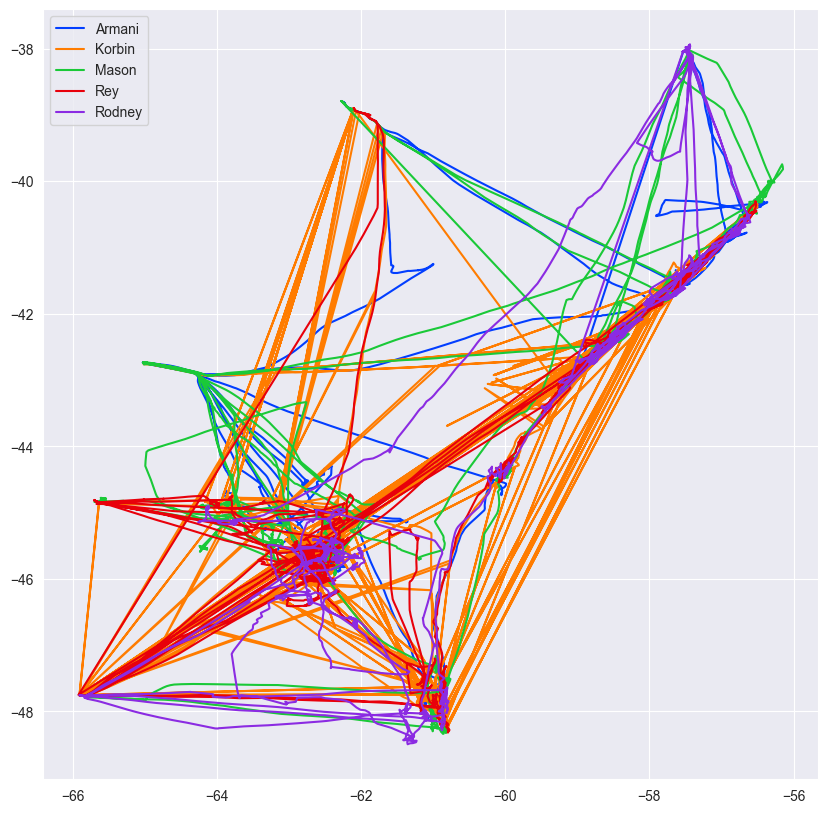

In [220]:
pd.to_datetime(ais['Date'],format='%Y-%m-%d %H:%M:%S')
colors = sns.color_palette('bright', 5)

# Group data by boat name
grouped_data = ais.groupby('BoatName')
fig, ax = plt.subplots(figsize=(10,10))
index=0
# Plot each group separately
for group_name, group_data in grouped_data:
    plt.plot(group_data['Longitude'], group_data['Latitude'], color=colors[index],label=group_name)
    index+=1

plt.legend()
plt.show()

Loading fishing dataset.

In [221]:
# Load the dataset
fishing = gpd.read_file('data/fishing.csv')
fishing

,BoatName,BoatID,Trip,Day,Kg,Duration,Lines,Temperature,Latitude,Longitude,geometry
0,Mason,111,2020-1,2020-01-12,11492,12,60,14.5,-45.1,-62.0,None
1,Mason,111,2020-1,2020-01-13,10582,12,60,14.5,-45.0333333333333,-62.1,None
2,Mason,111,2020-1,2020-01-18,21164,12,60,13.5,-44.8333333333333,-63.8166666666667,None
3,Mason,111,2020-1,2020-01-19,18980,12,60,14.0,-44.8333333333333,-63.8333333333333,None
4,Mason,111,2020-1,2020-01-20,16796,12,60,13.7,-44.866666666666696,-63.8166666666667,None
...,...,...,...,...,...,...,...,...,...,...,...
639,Rodney,115,2020-5,2020-06-21,21790,12,100,11.0,-42.0166666666667,-59.4666666666667,None
640,Rodney,115,2020-5,2020-06-22,20410,12,100,11.2,-42.05,-59.45,None
641,Rodney,115,2020-5,2020-06-25,23330,12,100,10.3,-42.0833333333333,-59.4166666666667,None
642,Rodney,115,2020-5,2020-06-26,8120,12,100,10.9,-41.9166666666667,-59.4333333333333,None


By plotting fishing data we observed three distinct fishing areas.

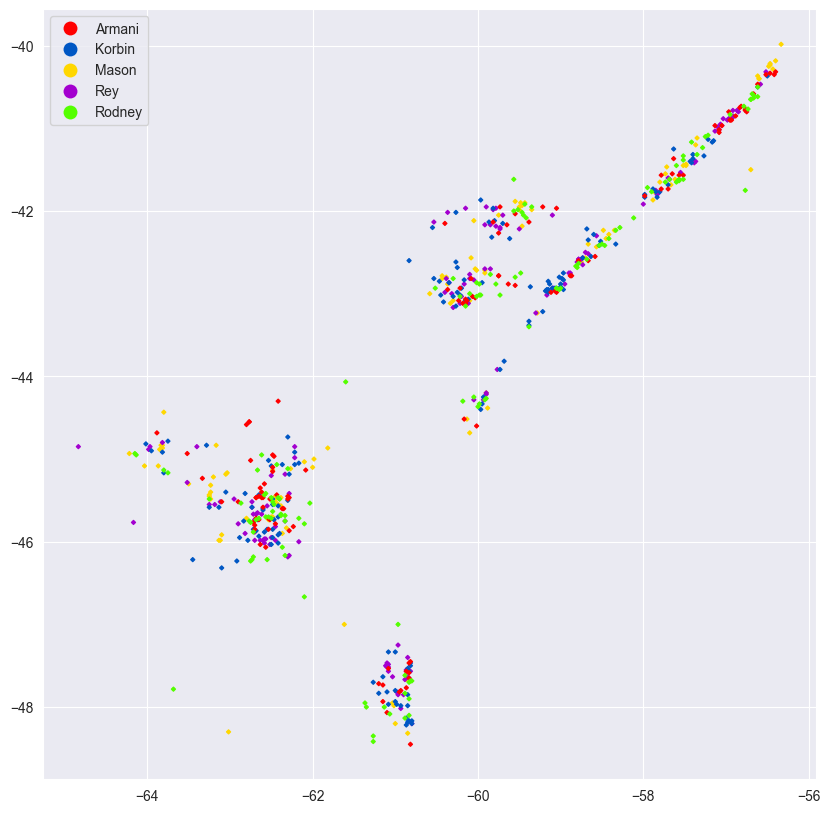

In [222]:
# Create a GeoDataFrame with Point geometry from the longitude and latitude columns
gdf = gpd.GeoDataFrame(fishing, geometry=gpd.points_from_xy(fishing.Longitude, fishing.Latitude))

# Plot the GeoDataFrame with smaller dots and larger figure size
fig, ax = plt.subplots(figsize=(10,10))
gdf.plot(ax=ax, column='BoatName', cmap='prism', legend=True, markersize=4,marker='D')
plt.show()

If we plot both fishing data and ais on the same graph we see that some fishing spots are not recorded as part of the trajectories of boats.

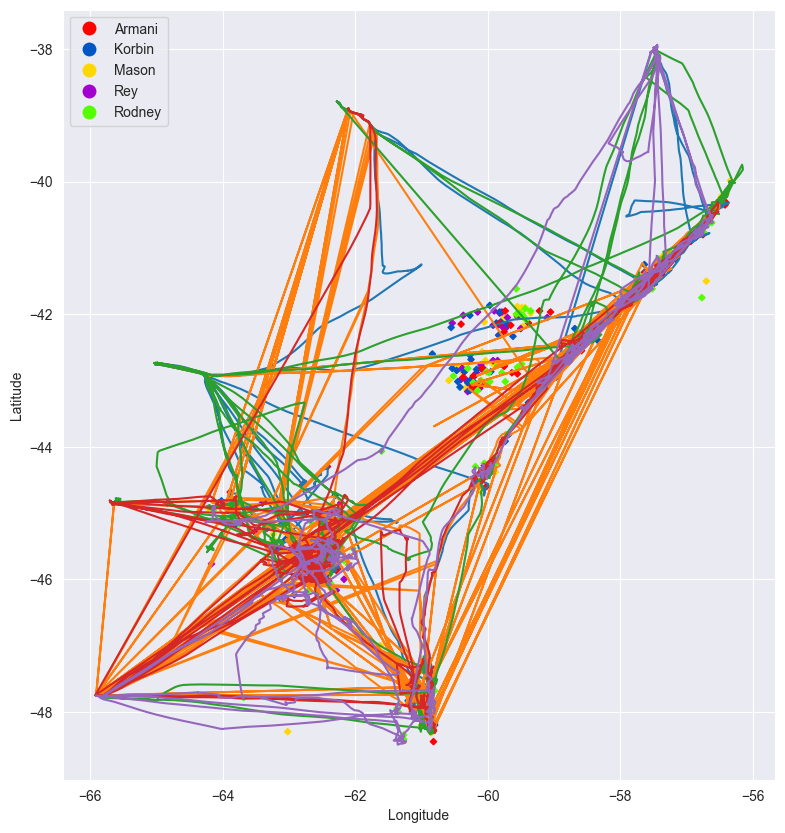

In [223]:
pd.to_datetime(ais['Date'],format='%Y-%m-%d %H:%M:%S')

# Group data by boat name
grouped_data = ais.groupby('BoatName')
fig, ax = plt.subplots(figsize=(10,10))
# Plot each group separately
for group_name, group_data in grouped_data:
    plt.plot(group_data['Longitude'], group_data['Latitude'], label=group_name)

gdf = gpd.GeoDataFrame(fishing, geometry=gpd.points_from_xy(fishing.Longitude, fishing.Latitude))

# Plot the GeoDataFrame with smaller dots and larger figure size

gdf.plot(ax=ax, column='BoatName', cmap='prism',legend=True, markersize=10,marker='D')


# Add x and y axis labels
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()

#### b. Once you preprocessed the data in points 1-3, you need to provide queries or additional programs to answer the following user requirements.
i. What is the distance travelled by each vessel, per month.

In [224]:
resampled_ais_data

,BoatID,Date,BoatName,Speed,Course,Latitude,Longitude
0,111,2020-01-01 08:20:00,Mason,0.1,N,-38.035000,-57.527770
12,111,2020-01-01 12:20:00,Mason,0.1,SE,-38.035270,-57.527770
72,111,2020-01-02 08:20:00,Mason,0.1,N,-38.035000,-57.527770
84,111,2020-01-02 12:20:00,Mason,0.2,SE,-38.035000,-57.527770
116,111,2020-01-02 23:00:00,Mason,0.2,E,-38.035000,-57.527770
...,...,...,...,...,...,...,...
58581,115,2020-06-12 22:20:00,Rodney,0.0,N,-38.045158,-57.539606
58582,115,2020-06-12 22:40:00,Rodney,0.0,N,-38.045158,-57.539600
58583,115,2020-06-12 23:00:00,Rodney,0.0,N,-38.045181,-57.539612
58584,115,2020-06-12 23:20:00,Rodney,0.0,N,-38.045191,-57.539612


To compute distance travelled by each vessel, per month we grouped data per month and **BoatName**. Then we used geodesic function to calculate distance between two points of boat sorted by time.
In March of 2020, the boat named Korbin traveled the furthest distance compared to other boats in the dataset.

In [225]:

# Convert the date column to a datetime object
resampled_ais_data['Date'] = pd.to_datetime(resampled_ais_data['Date'])
resampled_ais_data = resampled_ais_data.sort_values(['Date'], ascending=[True])
# Group the DataFrame by month and boat name and calculate the distance traveled for each group
grouped = resampled_ais_data.groupby([pd.Grouper(key='Date', freq='M'), 'BoatName'])
distance_by_month_and_boat = pd.DataFrame(columns=['month', 'boat_name', 'distance'])
for name, group in grouped:
    # Calculate the distance traveled for each consecutive pair of points
    distances = [geodesic(group.iloc[i][['Latitude', 'Longitude']].values,
                          group.iloc[i+1][['Latitude', 'Longitude']].values).km
                 for i in range(len(group)-1)]
    # Sum the distances to get the total distance traveled
    total_distance = np.sum(distances)
    # Add the distance to the output DataFrame
    distance_by_month_and_boat.loc[len(distance_by_month_and_boat)] = {'month': name[0], 'boat_name': name[1], 'distance': total_distance}

# Display the resulting DataFrame
print(distance_by_month_and_boat)


        month boat_name      distance
0  2020-01-31    Armani   5614.529405
1  2020-01-31    Korbin  46792.533875
2  2020-01-31     Mason  37631.154263
3  2020-01-31       Rey  55466.997133
4  2020-01-31    Rodney   2470.767836
5  2020-02-29    Armani  17534.950275
6  2020-02-29    Korbin  43565.249451
7  2020-02-29     Mason  65699.367938
8  2020-02-29       Rey  44516.528642
9  2020-02-29    Rodney  17745.453046
10 2020-03-31    Armani  15999.860515
11 2020-03-31    Korbin  74415.597058
12 2020-03-31     Mason  68824.519806
13 2020-03-31       Rey  55381.446038
14 2020-03-31    Rodney  23434.508747
15 2020-04-30    Armani   9007.588298
16 2020-04-30    Korbin  45549.223390
17 2020-04-30     Mason  12524.024263
18 2020-04-30       Rey  31902.045958
19 2020-04-30    Rodney   5695.905068
20 2020-05-31    Armani   7219.719288
21 2020-05-31    Korbin  40540.027442
22 2020-05-31     Mason  36060.857515
23 2020-05-31       Rey  48852.445223
24 2020-05-31    Rodney   9827.875812
25 2020-06-3

ii. What is the quantity of fish (in kg) caught by each vessel, per month.

To compute quantity of fish in kg caught by each vessel per month first we need to check if **Day** column is datetime type.

In [226]:
fishing_normalized.dtypes

BoatName               object
BoatID                  int64
Trip                   object
Day            datetime64[ns]
Lines                   int64
GridID                 object
Kg                      int64
Temperature           float64
Duration              float64
dtype: object

After that fishing data was grouped per **Day** in interval of one month and **BoatName** and sum function was used over **Kg** column containing value of caught fish.
Boat Rodney caught the highest amount of fish per month in April 2020, with a total of 969,890 kilograms.

In [227]:
# group by month and another column, and calculate the mean of a different column
grouped_fishing_by_month = fishing_normalized.groupby([pd.Grouper(key='Day', freq='M'), 'BoatName'])['Kg'].sum()

# display the resulting grouped DataFrame
print(grouped_fishing_by_month)

Day         BoatName
2020-01-31  Armani      213320
            Korbin      477278
            Mason       155376
            Rey         416847
            Rodney      261040
2020-02-29  Armani      410920
            Korbin      643168
            Mason       303160
            Rey         572862
            Rodney      463320
2020-03-31  Armani      132080
            Korbin      120420
            Mason        80600
            Rey         351125
            Rodney      117310
2020-04-30  Armani      541060
            Korbin      682923
            Mason       396693
            Rey         606806
            Rodney      969890
2020-05-31  Armani      253960
            Korbin      357353
            Mason       138736
            Rey         413969
            Rodney      482370
2020-06-30  Armani      439320
            Korbin      267441
            Mason       209234
            Rey         418775
            Rodney      364550
Name: Kg, dtype: int64


iii. Find Correlation between the quantity of fish caught and the temperature/chlorophyll. Tip: You can use DataFrame functionality to calculate correlations.

The correlation coefficients are values between -1 and 1 that indicate the strength and direction of the linear relationship between two variables. A correlation coefficient of 1 indicates a perfect positive correlation, a correlation coefficient of -1 indicates a perfect negative correlation, and a correlation coefficient of 0 indicates no correlation.

Correlation between fish caught and temperature or chlorophyll is negligible.

In [228]:
# calculate the correlation coefficients
corr_matrix = merged_df[['Kg', 'temperature', 'chlor_a']].corr()

# display the correlation matrix
print(corr_matrix)

                   Kg  temperature   chlor_a
Kg           1.000000     0.067007  0.060623
temperature  0.067007     1.000000 -0.054487
chlor_a      0.060623    -0.054487  1.000000
